#### Imports

In [9]:
import os, string, re, pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from resources.module import Utils, Transformer, FeatureEngineer, Predictor

#### Variables

In [10]:
cwd = os.getcwd()
project_dirpath = os.path.join(cwd, '..')
data_filename = 'spam.csv'
data_filepath = os.path.join(project_dirpath, 'data', data_filename)
stop_words = stopwords.words('english')

#### Functions

In [11]:
utils = Utils()
feature_engineer = FeatureEngineer()
transformer = Transformer()
predictor = Predictor()

#### Data Loading - EDA

##### Loading & Basic EDA

In [12]:
dataframe = pd.read_csv(data_filepath, encoding='utf-8')
dataframe.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
dataframe.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [14]:
dataframe.shape

(5572, 5)

In [15]:
dataframe.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [16]:
dataframe = dataframe.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [17]:
dataframe.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
dataframe.rename(columns = {'v1': 'spam', 'v2': 'message'}, inplace=True)
dataframe.head(1)

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."


In [19]:
dataframe.duplicated().sum()

403

In [20]:
dataframe.drop_duplicates(inplace=True)

##### Distribution

In [21]:
dataframe['spam'].value_counts()

ham     4516
spam     653
Name: spam, dtype: int64

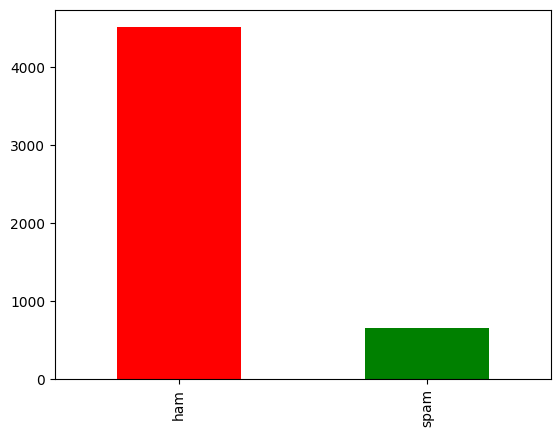

In [22]:
dataframe['spam'].value_counts().plot.bar(color= ['red', 'green'])
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'distribution.png'))
plt.show()

In [23]:
ham_percentage = np.round(dataframe['spam'].value_counts()[0] / dataframe.shape[0], 2)
spam_percentage = np.round(dataframe['spam'].value_counts()[1] / dataframe.shape[0], 2)
print(f"Spam: {spam_percentage} % and Ham: {ham_percentage} %")

Spam: 0.13 % and Ham: 0.87 %


##### Missing

In [24]:
dataframe.isnull().sum()

spam       0
message    0
dtype: int64

In [25]:
dataframe.duplicated().sum()

0

In [26]:
dataframe = dataframe.drop_duplicates()

#### Feature Enginnering and EDA

##### Feature Engineering & Data Transformation

In [27]:
dataframe = feature_engineer.create_features(dataframe)
dataframe.head(1)

,spam,message,length,sentences,words,average_words_in_sentence,stopwords,dollar_sign
0,ham,"Go until jurong point, crazy.. Available only ...",111,2,24,12.0,4,0


In [28]:
dataframe['message'] = dataframe['message'].apply(transformer.apply_transformation)
dataframe.head(3)

,spam,message,length,sentences,words,average_words_in_sentence,stopwords,dollar_sign
0,ham,go jurong point crazi avail bugi n great world...,111,2,24,12.0,4,0
1,ham,ok lar joke wif u oni,29,2,8,4.0,0,0
2,spam,free entri 2 wkli comp win fa cup final tkt 21...,155,2,37,18.5,5,0


In [29]:
# creating a new feature
dataframe['count_number_>3_chars'] = dataframe['message'].apply(feature_engineer.compute_number_count_with_more_than_3_chars)
dataframe.head()

,spam,message,length,sentences,words,average_words_in_sentence,stopwords,dollar_sign,count_number_>3_chars
0,ham,go jurong point crazi avail bugi n great world...,111,2,24,12.0,4,0,0
1,ham,ok lar joke wif u oni,29,2,8,4.0,0,0,0
2,spam,free entri 2 wkli comp win fa cup final tkt 21...,155,2,37,18.5,5,0,2
3,ham,u dun say earli hor u c alreadi say,49,1,13,13.0,2,0,0
4,ham,nah i dont think goe usf live around though,61,1,15,15.0,5,0,0


##### EDA

In [30]:
dataframe.columns

Index(['spam', 'message', 'length', 'sentences', 'words',
       'average_words_in_sentence', 'stopwords', 'dollar_sign',
       'count_number_>3_chars'],
      dtype='object')

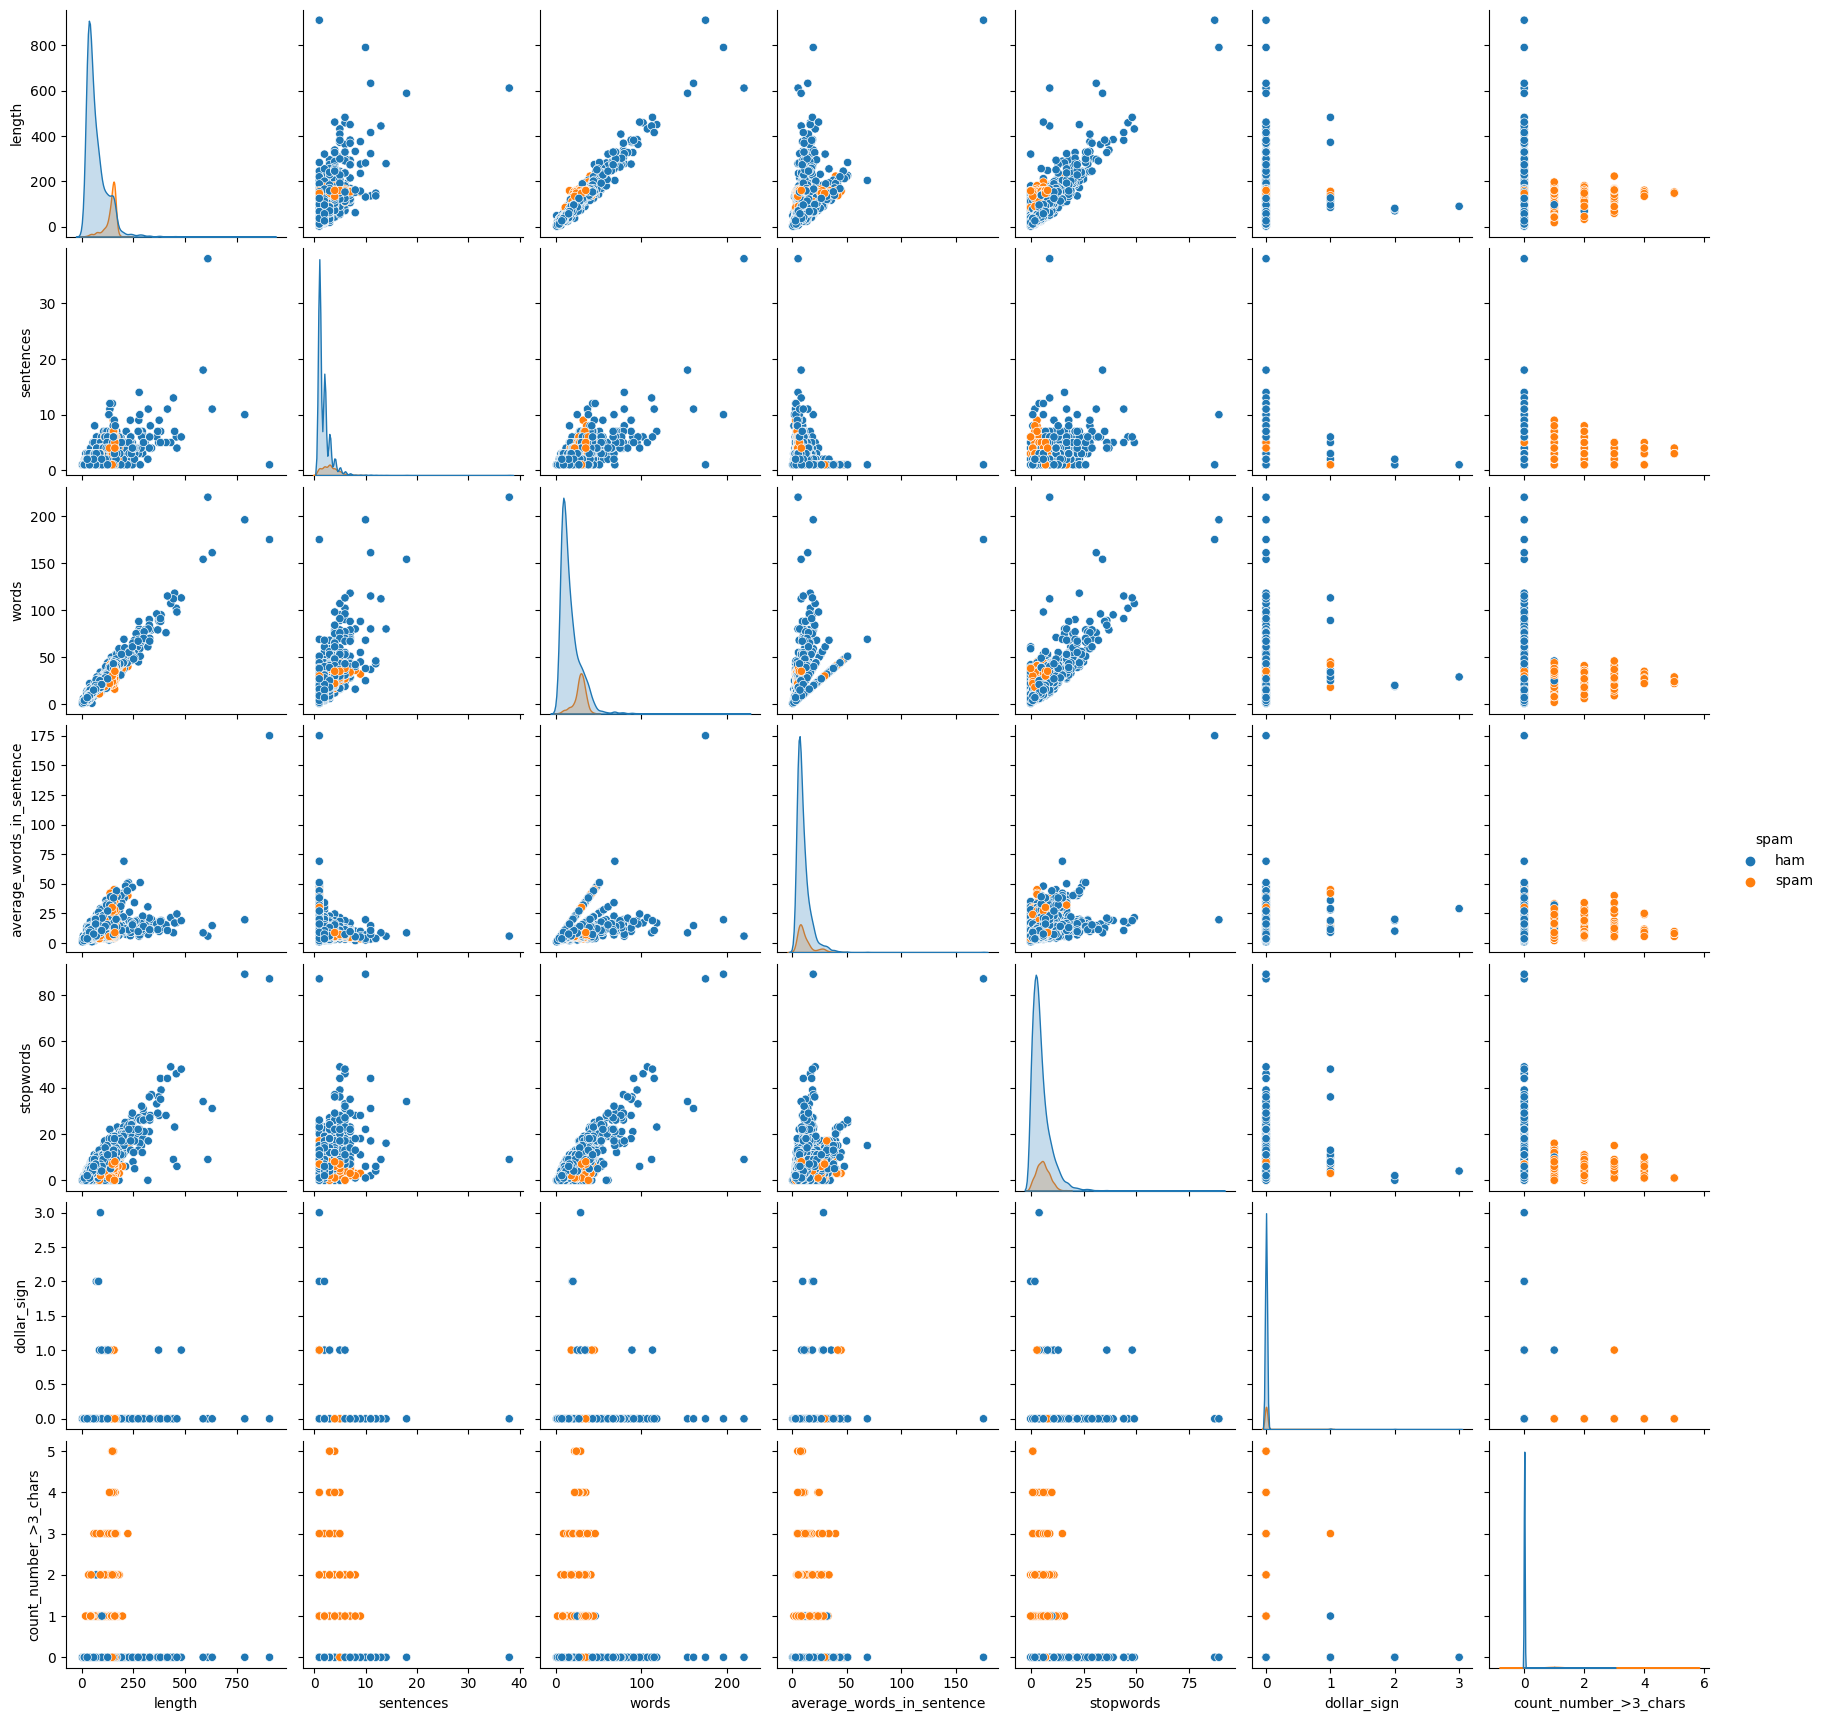

In [31]:
sns.pairplot(dataframe.drop('message', axis=1), hue='spam')
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'feats_pairplot.png'))
plt.show()

In [32]:
spam_dataframe = dataframe[dataframe['spam']==1]
ham_dataframe = dataframe[dataframe['spam']==0]

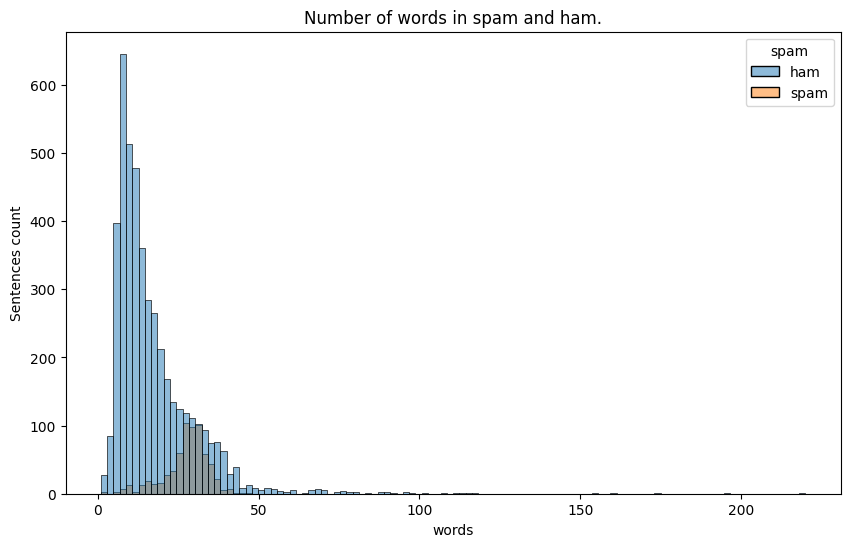

In [33]:
plt.figure(figsize=(10,6))
sns.histplot(dataframe, x='words', hue='spam')
plt.ylabel('Sentences count')
plt.title("Number of words in spam and ham.")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'no_of_words.png'))
plt.show()

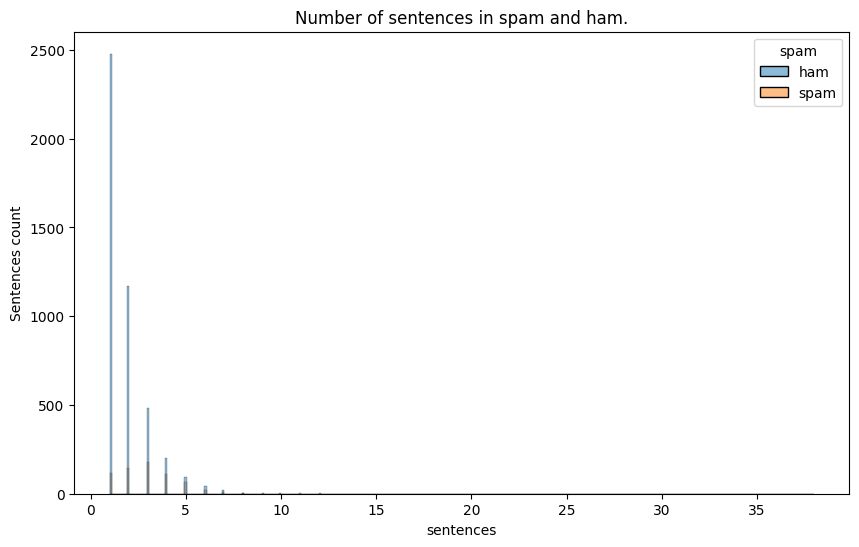

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(dataframe, x='sentences', hue='spam')
plt.ylabel('Sentences count')
plt.title("Number of sentences in spam and ham.")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'no_of_sentences.png'))
plt.show()

In [35]:
# Most of the spam messages have 3 sentences but ham have 1

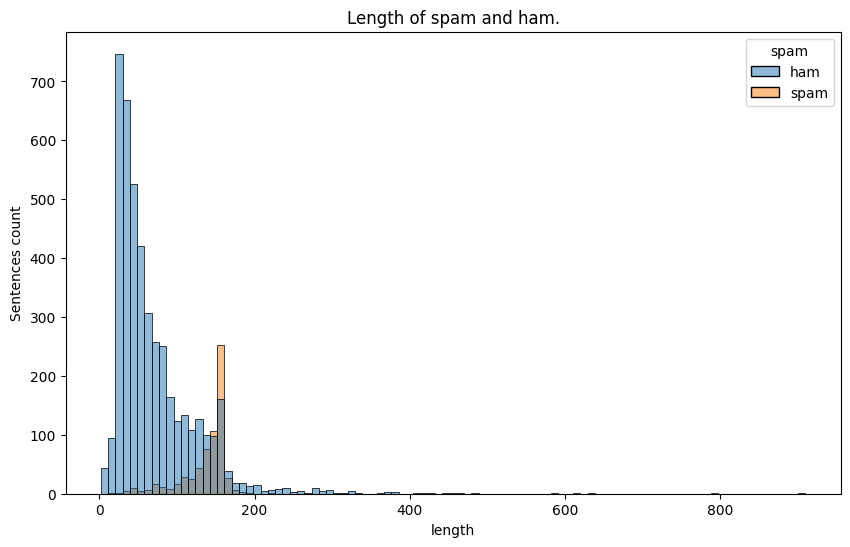

In [36]:
plt.figure(figsize=(10,6))
sns.histplot(dataframe, x='length', hue='spam')
plt.ylabel('Sentences count')
plt.title("Length of spam and ham.")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'length_of_message.png'))
plt.show()

In [37]:
# ham messages are short but most of the spam messages are long.

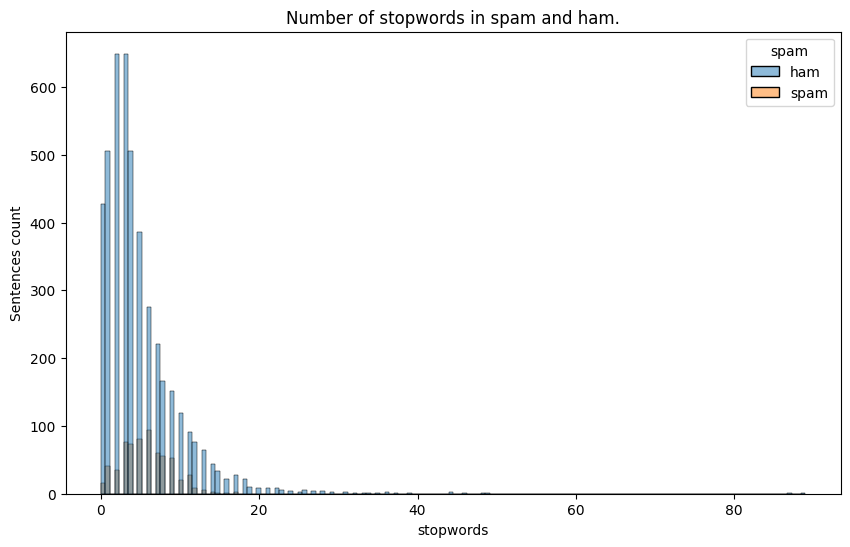

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(dataframe, x='stopwords', hue='spam')
plt.ylabel('Sentences count')
plt.title("Number of stopwords in spam and ham.")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'no_of_stopwords.png'))
plt.show()

In [39]:
# The stopwords count for ham and spam is almost same.

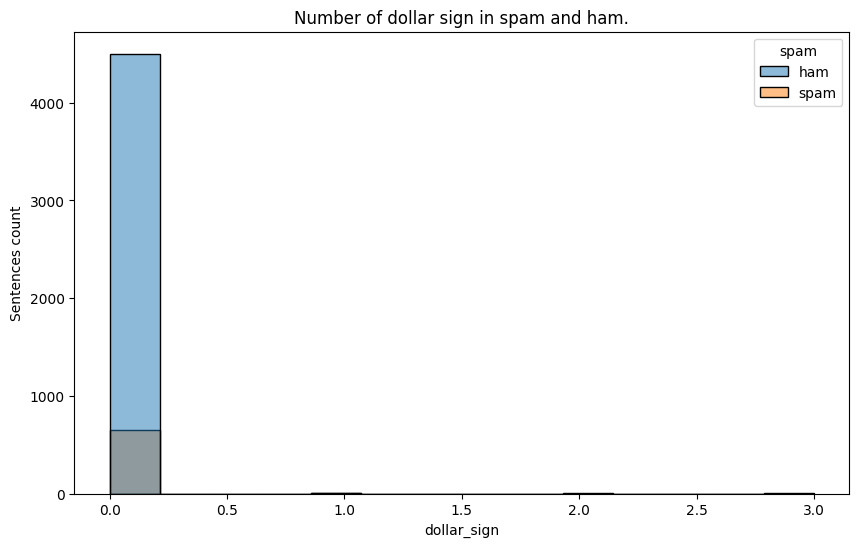

In [40]:
plt.figure(figsize=(10,6))
sns.histplot(dataframe, x='dollar_sign', hue='spam')
plt.ylabel('Sentences count')
plt.title("Number of dollar sign in spam and ham.")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'no_of_dollar_sign.png'))
plt.show()

In [41]:
# We've not detected any dollar sign

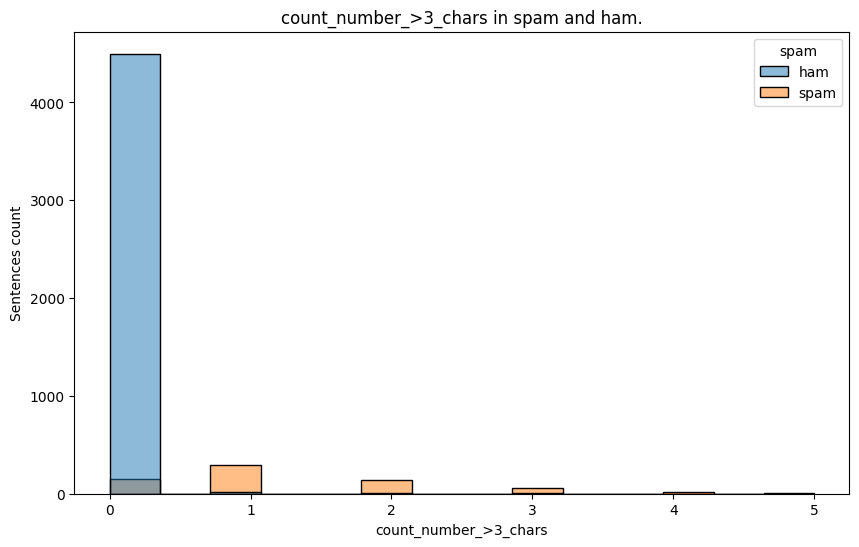

In [42]:
plt.figure(figsize=(10,6))
sns.histplot(dataframe, x='count_number_>3_chars', hue='spam')
plt.ylabel('Sentences count')
plt.title("count_number_>3_chars in spam and ham.")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'count_of_numbers_with_more_than_3_chars.png'))
plt.show()

In [43]:
# Only spam messages have numbers with more than 3 characters in them.

##### Target Encoding

In [44]:
label_encoder = LabelEncoder()
dataframe['spam'] = label_encoder.fit_transform(dataframe['spam'])

##### Heatmap & Word cloud

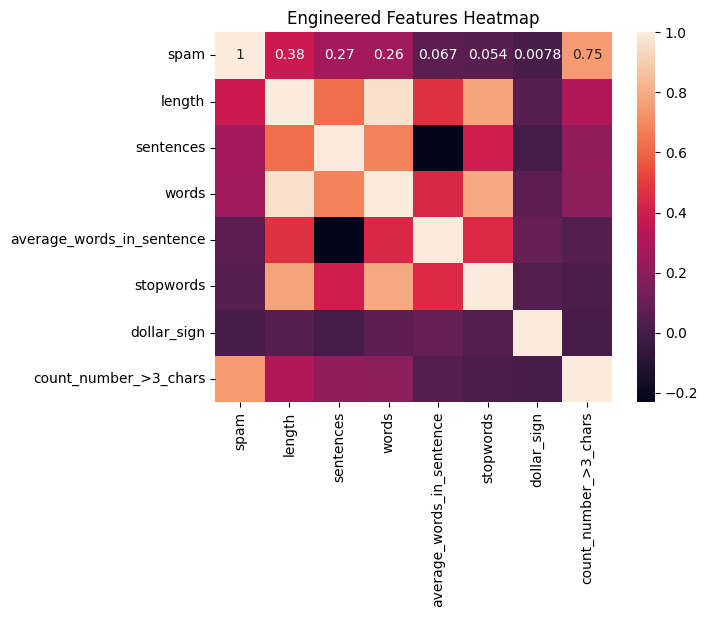

In [45]:
sns.heatmap(dataframe.corr(numeric_only=True), annot=True)
plt.title("Engineered Features Heatmap")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'features_heatmap.png'))
plt.show()

In [46]:
spam_dataframe = dataframe[dataframe['spam']==1]
ham_dataframe = dataframe[dataframe['spam']==0]

spam_corpus = utils.create_corpus(spam_dataframe['message'])
print(len(spam_corpus))
print(spam_corpus)

ham_corpus = utils.create_corpus(ham_dataframe['message'])
print(len(ham_corpus))
print(ham_corpus)

2717
{'secur', 'yourinclus', '4712', 'subpoli', 'packag', 'arsen', 'cute', 'may', '731', 'check', 'peopl', 'receivea', 'lingeri', '350', 'fit', 'call2optoutj5q', '09061744553', 'no1', 'hardcor', 'experi', 'oz', '09050000301', 'book', 'cashbal', 'gift', 'shot', 'vpod', '09065171142stopsms08718727870150ppm', 'tbspersolvo', 'cost�375max', 'text', 'k61', '07808726822', 'respond', '449050000301', '09071512432', 'qlynnbv', 'messagesim', 'log', 'canari', 'tsunami', 'dont', '09066368327', 'g696ga', 'nick', 'landmark', 'sun0819', 'fix', 'leav', 'lord', 'chik', 'content', 'simpl', 'includ', '09061743810', 'within', 'gr8prize', 'bcmsfwc1n3xx', '087104711148', 'sm', 'mid', 'valentin', 'contact', 'mad2', 'mjzgroup', '08718711108', 'ngage', '08712402050', 'sonyericsson', 'noworriesloanscom', 'am', '09050280520', 'see', 'mind', '83049', 'posh', 'usher', 'gossip', 'avbl', 'doublemin', '5we', 'pictur', 'a�150', '40411', 'warranti', '88888', '750', 'draw', 'rp176781', 'websit', '0870k', 'me', 'lucozad',

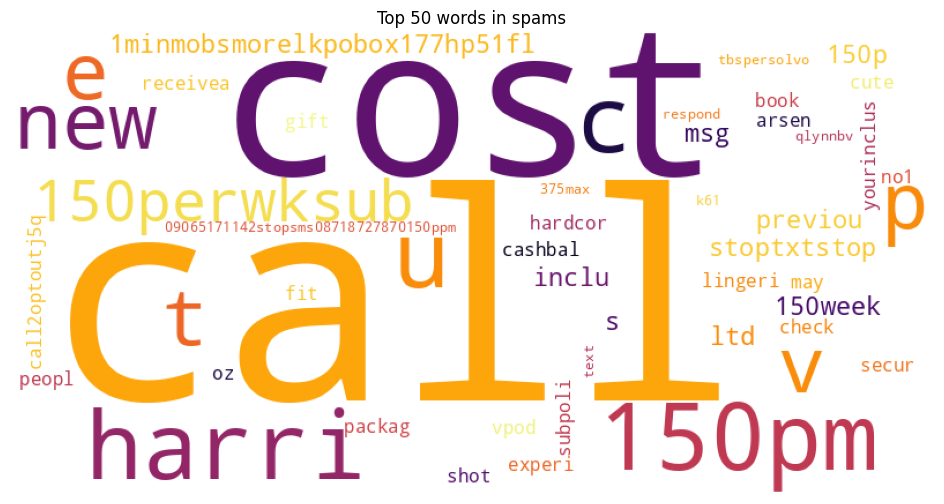

In [47]:
from wordcloud import WordCloud
figure = WordCloud(width = 800, height = 400, max_words=50, background_color="white", colormap='inferno')
figure.generate(" ".join(spam_corpus))

plt.figure(figsize=(14,6))
plt.title("Top 50 words in spams")
plt.axis('off')
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'top_words_in_spam.png'))
plt.imshow(figure)
plt.show()

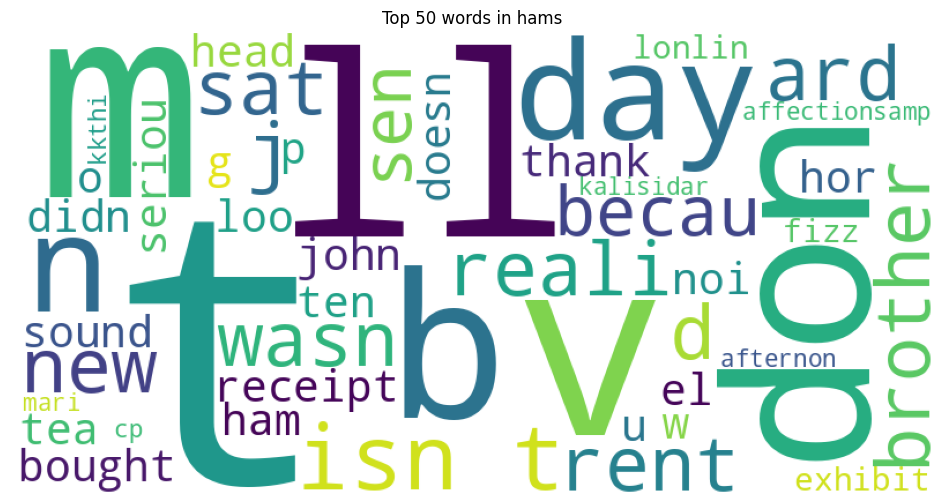

In [48]:
from wordcloud import WordCloud
figure = WordCloud(width = 800, height = 400, max_words=50, background_color="white", colormap='viridis')
figure.generate(" ".join(ham_corpus))

plt.figure(figsize=(14,6))
plt.title("Top 50 words in hams")
plt.axis('off')
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'top_words_in_ham.png'))
plt.imshow(figure)
plt.show()

We should use only the count_number_>3_chars and 1 of the length, sentences and words feature. So we'll use:
- count_number_>3_chars
- length

#### Input Encoding and Model Building

##### Encoding & Train Test split

In [49]:
count_vectorizer = CountVectorizer(max_features=5000)
vectorized_messages = count_vectorizer.fit_transform(dataframe['message']).toarray()

In [50]:
vectorized_messages = pd.DataFrame(vectorized_messages)

In [51]:
features_gonna_use = dataframe[['length', 'count_number_>3_chars', 'spam']].reset_index(drop=True)
vectorized_messages = vectorized_messages.reset_index(drop=True)

final_dataframe = pd.concat([features_gonna_use, vectorized_messages], axis=1)
final_dataframe.head()

,length,count_number_>3_chars,spam,0,1,2,3,4,5,6,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,155,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
del dataframe, features_gonna_use, vectorized_messages, spam_dataframe, ham_dataframe, spam_corpus, ham_corpus

In [53]:
final_dataframe.columns = final_dataframe.columns.astype(str)
x_train, x_test, y_train, y_test = train_test_split(final_dataframe.drop('spam', axis=1), final_dataframe['spam'], test_size=0.2, random_state=20)

In [54]:
y_test

2070    0
1200    0
1420    1
4136    0
2680    0
       ..
3657    0
276     0
1520    0
612     0
231     0
Name: spam, Length: 1034, dtype: int32

In [55]:
y_train.value_counts()

0    3628
1     507
Name: spam, dtype: int64

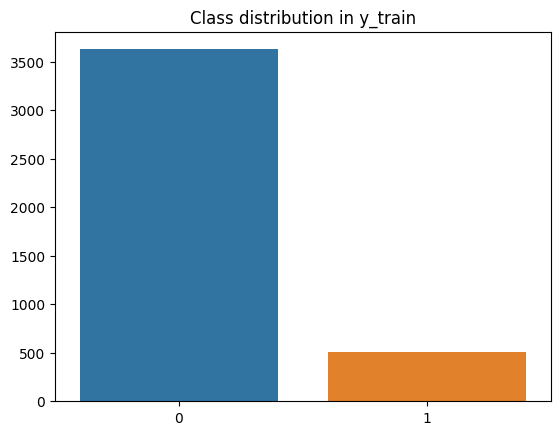

In [56]:
y_train_valuecounts = y_train.value_counts()
sns.barplot(x=y_train_valuecounts.index, y=y_train_valuecounts.values)
plt.title("Class distribution in y_train")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'distribution_y_train.png'))
plt.show()

In [57]:
y_test.value_counts()

0    888
1    146
Name: spam, dtype: int64

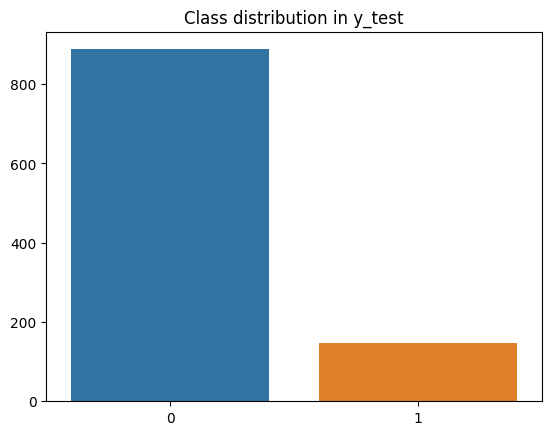

In [58]:
y_test_valuecounts = y_test.value_counts()
sns.barplot(x=y_test_valuecounts.index, y=y_test_valuecounts.values)
plt.title("Class distribution in y_test")
plt.savefig(os.path.join(project_dirpath, 'src', 'visuals', 'distribution_y_test.png'))
plt.show()

The distribution we've in both dataframes is of almost equally ratio.

##### Model Building

In [59]:
models = {
    'Gaussian_NB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier()
}
results = {
    'model': [],
    'accuracy': [],
    'precision': [],
    'f1_score': []
}

for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    results['model'].append(model_name)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['f1_score'].append(f1)

c:\Users\Dmm\anaconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
results

{'model': ['Gaussian_NB',
  'BernoulliNB',
  'MultinomialNB',
  'LogisticRegression',
  'RandomForest'],
 'accuracy': [0.8771760154738878,
  0.9806576402321083,
  0.988394584139265,
  0.9787234042553191,
  0.9816247582205029],
 'precision': [0.5394190871369294,
  0.9846153846153847,
  0.9855072463768116,
  0.9769230769230769,
  1.0],
 'f1_score': [0.6718346253229974,
  0.927536231884058,
  0.9577464788732394,
  0.9202898550724637,
  0.9304029304029304]}

In [61]:
pd.DataFrame(results)

,model,accuracy,precision,f1_score
0,Gaussian_NB,0.877176,0.539419,0.671835
1,BernoulliNB,0.980658,0.984615,0.927536
2,MultinomialNB,0.988395,0.985507,0.957746
3,LogisticRegression,0.978723,0.976923,0.920290
4,RandomForest,0.981625,1.000000,0.930403


The best model we've is RandomForest as we're more concerned about precision. Let's optimize it.

##### Fine Tuning
Not increased the performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=20)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=3, verbose=2, scoring=['accuracy', 'precision', 'f1'], refit='f1')

# Fit the model
grid_search.fit(x_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Evaluate the tuned model on the test data
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_test)
print(classification_report(y_test, y_pred))


In [ ]:
best_model = RandomForestClassifier(min_samples_split=7)
best_model.fit(x_train, y_train)

train_y_predict = best_model.predict(x_train.sample(2000, random_state=20))
y_predict = best_model.predict(x_test)

train_accuracy = accuracy_score(y_train.sample(2000, random_state=20), train_y_predict)
test_accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
print(f"""train_accuracy: {train_accuracy} \
        \ntest accuracy: {accuracy} \
        \nprecision: {precision} \
        \nf1: {f1}""")

#### Best Model
- Train accuracy: 1.0
- Test accuracy: 0.9825918762088974         
- Precision: 1.0         
- F1: 0.922509225092251

In [62]:
best_model = RandomForestClassifier()
best_model.fit(x_train, y_train)

train_y_predict = best_model.predict(x_train.sample(2000, random_state=20))
y_predict = best_model.predict(x_test)

train_accuracy = accuracy_score(y_train.sample(2000, random_state=20), train_y_predict)
test_accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
print(f"""train_accuracy: {train_accuracy} \
        \ntest accuracy: {accuracy} \
        \nprecision: {precision} \
        \nf1: {f1}""")

train_accuracy: 1.0         
test accuracy: 0.9816247582205029         
precision: 1.0         
f1: 0.9185185185185185


In [63]:
# saving model and vectorizer
pickle.dump(best_model, open("model.pkl", "wb"))
pickle.dump(count_vectorizer, open("vectorizer.pkl", "wb"))

#### Predictions

In [92]:
message = "How are you. Are you doing fine. You won a cash prize of $5000. Contact on: 02330234344"
predictor.predict_class(message)

'Spam'